# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [ ]:
#from moviepy.editor import *

## Env setup

In [ ]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [ ]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [11]:
# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [12]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

In [13]:
print PATH_TO_LABELS 
print PATH_TO_CKPT 


data/mscoco_label_map.pbtxt
faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb


## Load a (frozen) Tensorflow model into memory.

In [14]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [15]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [16]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [17]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

(636, 1024, 3)
(1, 636, 1024, 3)
[[[  3.76965590e-02   3.44727486e-02   8.64466965e-01   2.95450985e-01]
  [  8.58229101e-02   3.83688748e-01   9.55396354e-01   9.75535810e-01]
  [  1.52562466e-03   2.75450706e-01   8.59520674e-01   6.48365021e-01]
  [  1.33794465e-03   7.04304397e-01   1.02863833e-01   7.96590805e-01]
  [  2.66656256e-03   5.35046339e-01   2.52525687e-01   7.04693079e-01]
  [  1.63371786e-02   9.19444621e-01   7.83610284e-01   1.00000000e+00]
  [  0.00000000e+00   1.88331142e-01   7.41240442e-01   8.45557928e-01]
  [  0.00000000e+00   4.15817499e-01   2.72906095e-01   7.12693155e-01]
  [  0.00000000e+00   8.18407476e-01   8.83867085e-01   9.87759292e-01]
  [  9.88878869e-03   3.51084650e-01   3.62309158e-01   7.11505234e-01]
  [  7.53555596e-02   2.33733729e-01   8.93119931e-01   8.40855956e-01]
  [  6.38326037e-06   1.06503762e-01   3.34110379e-01   7.14495957e-01]
  [  2.07118422e-01   2.73109376e-01   4.31022197e-01   3.41204643e-01]
  [  0.00000000e+00   7.0910894

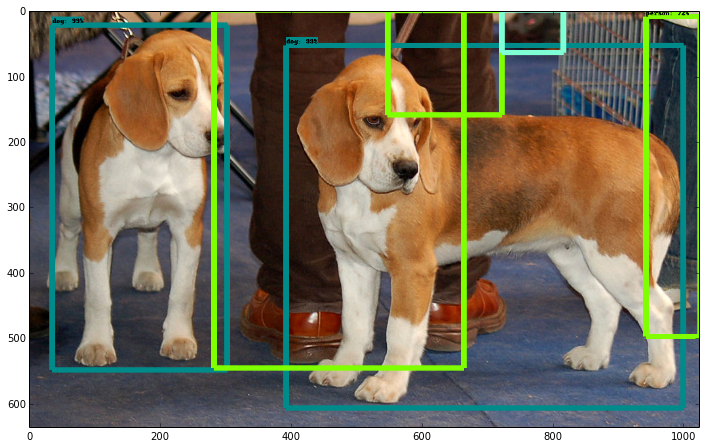

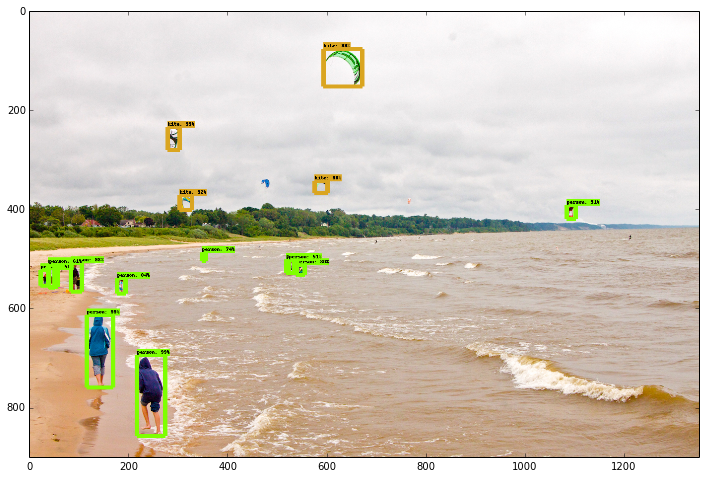

In [18]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      print image_np.shape 
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      print image_np_expanded.shape
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
         
     
        
      # Visualization of the results of a detection.
    
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [40]:
cv2.imwrite("./test_images/cv.jpeg",image_np)
print num_detections

[ 100.]


In [39]:
print classes.shape
print scores.shape
print boxes.shape

print boxes
print scores
print classes

(1, 100)
(1, 100)
(1, 100, 4)
[[[ 0.08768657  0.43868989  0.17222153  0.49673432]
  [ 0.77253753  0.16090721  0.9534111   0.20302373]
  [ 0.68231732  0.08621703  0.84473848  0.12558436]
  [ 0.26285309  0.20671414  0.31403294  0.22412653]
  [ 0.38249844  0.42567495  0.40919945  0.44498408]
  [ 0.566284    0.06250212  0.63086826  0.07864097]
  [ 0.41465586  0.22474943  0.44851595  0.24261682]
  [ 0.60014576  0.13114229  0.63481444  0.14377242]
  [ 0.57099009  0.39862174  0.59252912  0.41077092]
  [ 0.55835456  0.38340598  0.58952117  0.39515638]
  [ 0.54242629  0.25763041  0.56199104  0.26378924]
  [ 0.56865674  0.02839309  0.62047225  0.0426233 ]
  [ 0.56970191  0.02993603  0.6213237   0.03797429]
  [ 0.58150333  0.01741765  0.61696255  0.02960353]
  [ 0.5598594   0.38728738  0.58967841  0.39898041]
  [ 0.43674949  0.80143362  0.46885937  0.8146255 ]
  [ 0.37684405  0.34667012  0.40039462  0.3595081 ]
  [ 0.43628144  0.80111635  0.46968395  0.81541699]
  [ 0.5683161   0.39487344  0.5929